In [50]:
"""
Author: ByungUk Park
Written Date: 10/15/2025

"""

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from matplotlib.ticker import MultipleLocator

plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'mathtext.default': 'regular',
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.linewidth': 1.0,
    'figure.dpi': 300
})


### 1. Per-protein ROC AUC tracking: train, validation, test, epoch time

In [19]:
log_path = "input/train_log.txt"

auc_mean_training = []
auc_median_training = []
auc_mean_valid = []
auc_median_valid = []
valid_auc = []
auc_mean_test = []
auc_median_test = []
testing_auc = []
epoch_time = []

with open(log_path, 'r') as f:
    for line in f:
        # Check if the line should be parsed
        if line.startswith('Epoch ran on'):
            fetched_ptn_num = int(line.strip().split()[3])
            # skipped_ptn = next(f, None)
            # skipped_ptn_num = int(skipped_ptn.strip().split()[0])
        if line.startswith("Per protein AUC mean (training):"):
            auc_train = line
            fields = auc_train.strip().split()
            auc_mean_training.append(float(fields[5].rstrip(';')))
            auc_median_training.append(float(fields[7]))
            auc_valid = next(f, None)
            fields = auc_valid.strip().split()
            auc_mean_valid.append(float(fields[5].rstrip(';')))
            auc_median_valid.append(float(fields[7]))
            auc_test = next(f, None)
            fields = auc_test.strip().split()
            auc_mean_test.append(float(fields[5].rstrip(';')))
            auc_median_test.append(float(fields[7]))
        if line.startswith('Validation auc (all points):'):
            fields = line.strip().split()
            valid_auc.append(float(fields[-1]))
        if line.startswith('Testing auc (all points):'):
            fields = line.strip().split()
            testing_auc.append(float(fields[-1]))
        if line.startswith('Epoch took'):
            fields = line.strip().split()
            epoch_time.append(float(fields[-1].rstrip('s')))


In [20]:
epoch_num = 50
xaxis_major_loc = epoch_num // 5

# pmf plot func
def plot1D(epoch_num, xaxis_major_loc, data,title, size=(3, 1.9)):
    fig, ax = plt.subplots()
    ax.figure.set_size_inches(size)
    ax.plot(np.arange(epoch_num)+1, data, color='tab:blue')
    ax.set_xlabel('epoch', fontsize=8)
    ax.set_ylabel('ROC AUC\n(per protein)', fontsize=8)
    ax.set_xlim(xmin=1,xmax=epoch_num)
    ax.set_ylim(0.0,1)
    ax.xaxis.set_major_locator(MultipleLocator(xaxis_major_loc))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    # ax.yaxis.set_major_locator(MultipleLocator(0.1))
    # ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(which='major', length=4, width=1, direction='out', bottom=True, left=True)
    plt.tight_layout()
    # plt.legend()
    # plt.savefig(f"{save_path}/{title}.eps", format='eps', bbox_inches = 'tight', dpi=300)
    plt.show()

def plot2D(epoch_num, xaxis_major_loc, data_mean, data_med,  title, size=(3, 1.9)):
    fig, ax = plt.subplots()
    ax.figure.set_size_inches(size)
    ax.plot(np.arange(epoch_num)+1, data_med, label="median", color='tab:blue')
    ax.plot(np.arange(epoch_num)+1, data_mean, label="mean", color='tab:orange')
    ax.set_xlabel('epoch', fontsize=8)
    ax.set_ylabel('ROC AUC\n(per protein)', fontsize=8)
    ax.set_ylim(0.0,1)
    ax.set_xlim(xmin=1,xmax=epoch_num)
    ax.xaxis.set_major_locator(MultipleLocator(xaxis_major_loc))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    # ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(which='major', length=4, width=1, direction='out', bottom=True, left=True)
    plt.tight_layout()
    plt.legend(fontsize=6)
    # plt.savefig(f"{save_path}/{title}.eps", format='eps', bbox_inches = 'tight', dpi=300)
    plt.show()


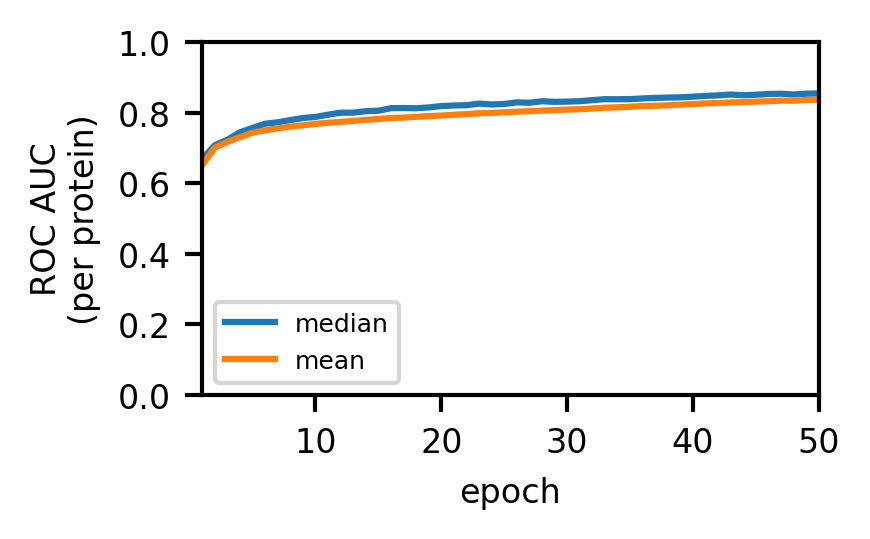

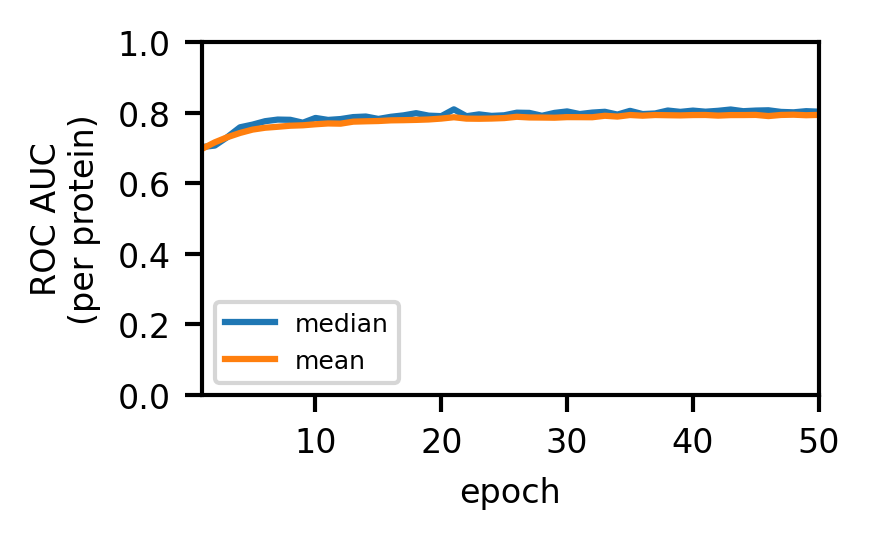

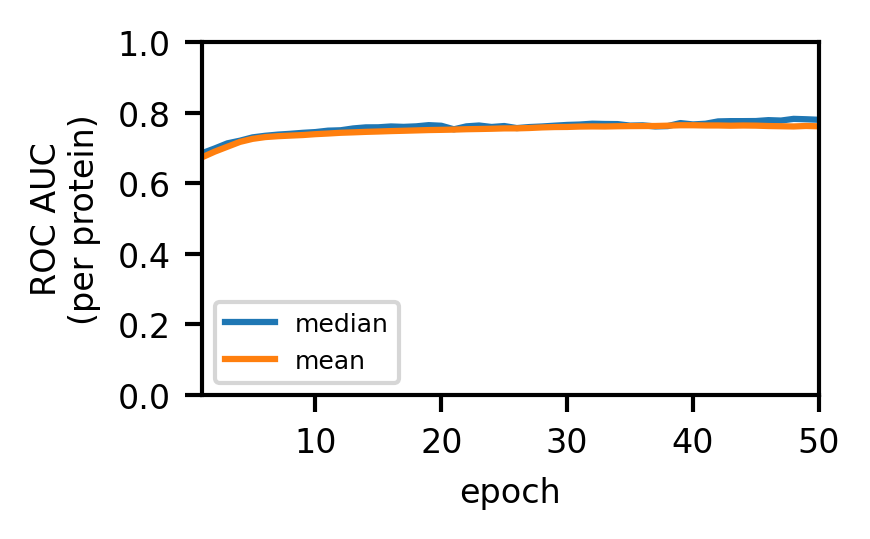

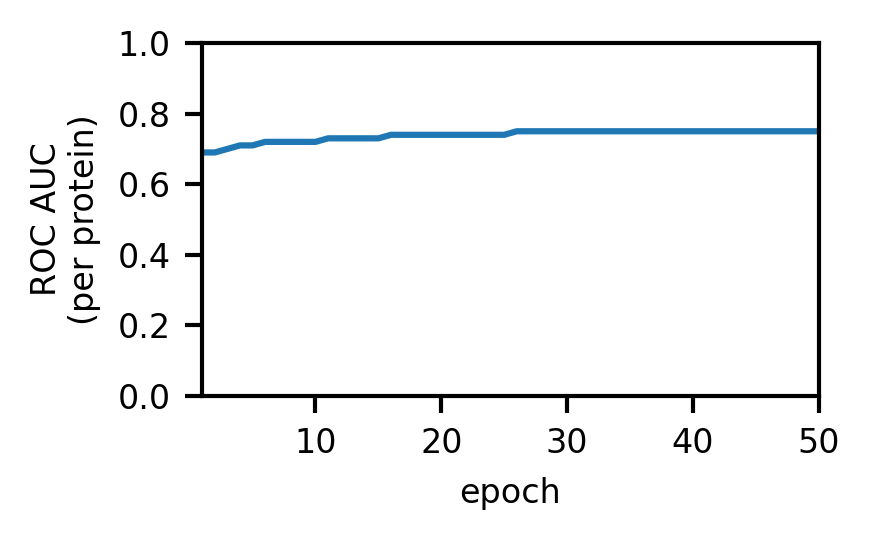

In [22]:
plot2D(epoch_num, xaxis_major_loc, auc_mean_training, auc_median_training, "Per protein AUC (training)")
plot2D(epoch_num, xaxis_major_loc, auc_mean_valid, auc_median_valid, "Per protein AUC (validation)")
plot2D(epoch_num, xaxis_major_loc, auc_mean_test, auc_median_test, "Per protein AUC (test)")

plot1D(epoch_num, xaxis_major_loc, testing_auc, "Testing auc (all points)")
# plot1D(epoch_num, xaxis_major_loc, valid_auc, "Validation auc (all points)")

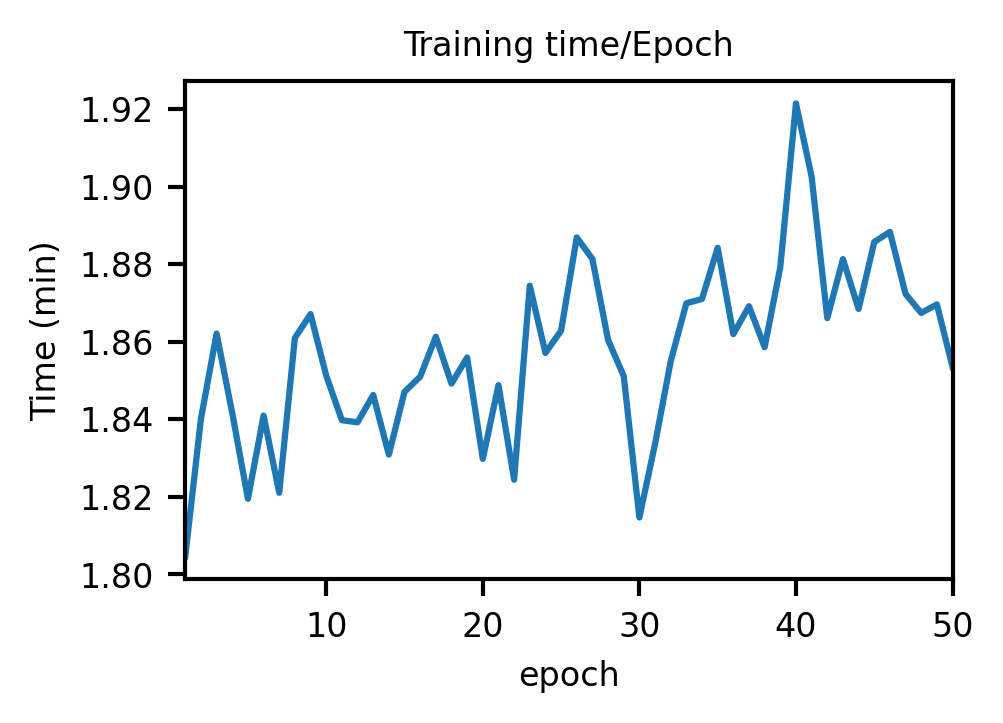

Total time for training (50 epochs): 1.55 hours


In [23]:
plt.figure(figsize=(3.3, 2.2))
plt.plot(np.arange(epoch_num)+1, [x/60 for x in epoch_time], color='tab:blue')
plt.xlabel('epoch', fontsize=8)
plt.ylabel('Time (min)', fontsize=8)
plt.xlim(xmin=1,xmax=epoch_num)
plt.title("Training time/Epoch", fontsize=8)
plt.tick_params(which='major', length=4, width=1, direction='out', bottom=True, left=True)
# plt.savefig(f"{save_path}/epoch_time.eps", format='eps', bbox_inches = 'tight', dpi=300)
plt.show()

print("Total time for training ({} epochs): {:.2f} hours".format(epoch_num, (np.sum([x/60 for x in epoch_time]))/60))

### 2. Test set ROC AUC distribution

In [25]:
log_path = "input/test_log.txt"

pdb_id_list = []
pdb_count = 0

with open(log_path, 'r') as f:
    for line in f:
        # Check if the line should be parsed
        if line.startswith('No ROC AUC computed for protein'):
            # Parse the next line (replace this with your parsing logic)
            next_line = next(f, None)
            fields = next_line.strip().split('/')
            # Save CV & PMF to array
            pdb_id_list.append(fields[-1].rstrip('.ply'))
            pdb_count += 1

print(pdb_count)
print(pdb_id_list)
if pdb_count > 0:
    print(f"Error cases: {pdb_id_list} would probably include NaN values in their input_feat.npy files.")
    print("possible cause: NaN value usually occured during H, K curvature matrices calculation in the fingerprinting step. Check the input_feat.npy files.")


0
[]


Computed the ROC AUC for 130 proteins


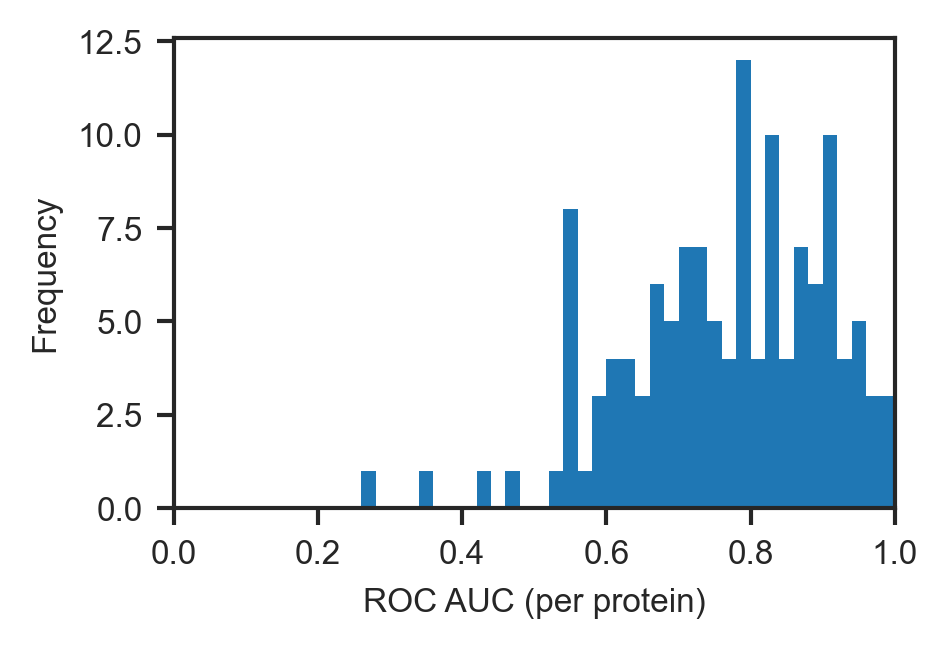

In [27]:
### ROC AUC distribution check
import seaborn as sns

sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})
plt.figure(figsize=(3.5, 2.5))

roc_auc_list = []
pdb_id_list = []
pdb_count = 0

with open(log_path, 'r') as f:
    for line in f:
        # Check if the line should be parsed
        if line.startswith('ROC AUC score for protein'):           
            # Parse the line (replace this with your parsing logic)
            parsed_line = line.strip().split()
            # Save CV & PMF to array
            roc_auc_list.append(np.float32(parsed_line[-1]))
            pdb_id_list.append(parsed_line[-3])
            pdb_count += 1

# Plot the histogram
plt.hist(roc_auc_list, bins=50, range=(0.0, 1.0), density=False, alpha=1.0, color='tab:blue')
plt.xlim(0.0, 1.0)
# Add a title and labels
plt.xlabel('ROC AUC (per protein)', fontsize=8)   # fontsize=10
plt.ylabel('Frequency', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(MultipleLocator(2.5))
plt.tick_params(axis='x', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
plt.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
plt.gca().spines['top'].set_linewidth(1.0)
plt.gca().spines['bottom'].set_linewidth(1.0)
plt.gca().spines['right'].set_linewidth(1.0)
plt.gca().spines['left'].set_linewidth(1.0)
plt.tight_layout()


# Show the plot
print(f"Computed the ROC AUC for {pdb_count} proteins")
# plt.savefig(save_file_name, format='eps', bbox_inches = 'tight', dpi=300)
plt.show()


In [29]:
# ROC AUC max, min PDB_ID search

max_idx = np.argmax(roc_auc_list)
best_pred_pdb = pdb_id_list[max_idx]
print("PDB_ID w/ highest ROC AUC\n{}: {}".format(best_pred_pdb, roc_auc_list[max_idx]))

min_idx = np.argmin(roc_auc_list)
worst_pred_pdb = pdb_id_list[min_idx]
print("PDB_ID w/ lowest ROC AUC\n{}: {}".format(worst_pred_pdb, roc_auc_list[min_idx]))

PDB_ID w/ highest ROC AUC
4Y1T_A: 1.0
PDB_ID w/ lowest ROC AUC
2ADZ_A: 0.27000001072883606


### 3. 5-fold CV mask test

In [40]:
# data parsing
import numpy as np
import pandas as pd
import re

mask_sets = ['hbond', 'elec', 'hphob', 'geom', 'chem', 'geom\nhbond', 'geom\nelec', 'geom\nhphob', 'geom\nhbond\nelec', 'geom\nhbond\nhphob', 'geom\nelec\nhphob', "all feat"]

mask_map = {
    'hbond': 'hbond_only',
    'elec': 'pb_only',
    'hphob': 'hphob_only',
    'geom': 'shape_only',
    'chem': 'chem_only',
    'geom\nhbond': 'shape_hbond',
    'geom\nelec': 'shape_pb',
    'geom\nhphob': 'shape_hphob',
    'geom\nhbond\nelec': 'shape_hbond_pb',
    'geom\nhbond\nhphob': 'shape_hbond_hphob',
    'geom\nelec\nhphob': 'shape_pb_hphob',
    "all feat": "all_feat"
}

pattern = re.compile(
    r">*\s*Split\s+(\d+)\s+CV test done.*?"
    r">*\s*Per protein AUC mean \(training\):\s*([0-9.]+)\s*;\s*median:\s*([0-9.]+).*?"
    r">*\s*Per protein AUC mean \(validation\):\s*([0-9.]+)\s*;\s*median:\s*([0-9.]+).*?"
    r">*\s*Validation auc \(all points\):\s*([0-9.]+)",
    re.DOTALL | re.IGNORECASE
)

# Read from your log file
rows, issues = [], []

for mask_set in mask_sets:
    mask_name = mask_map.get(mask_set)
    if not mask_name:
        issues.append((mask_set, "no mapping for mask_set"))
        continue

    log_file = os.path.join("input/5-fold_cv", f"{mask_name}.txt")
    if not os.path.exists(log_file):
        issues.append((mask_set, f"missing file: {log_file}"))
        continue

    with open(log_file, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()

    matches = pattern.findall(text)
    if not matches:
        issues.append((mask_set, "no matches in log.txt (regex didn’t find a split block)"))
        continue

    for m in matches:
        train_mean, train_median, val_mean, val_median, val_all = map(float, m[1:])
        # If mask_set already exists, append to lists, else create new lists
        if not any(row["mask_set"] == mask_set for row in rows):
            rows.append({
                "mask_set": mask_set,
                "train_mean": [train_mean],
                "train_median": [train_median],
                "val_mean": [val_mean],
                "val_median": [val_median],
                "val_all_points": [val_all]
            })
        else:
            for row in rows:
                if row["mask_set"] == mask_set:
                    row["train_mean"].append(train_mean)
                    row["train_median"].append(train_median)
                    row["val_mean"].append(val_mean)
                    row["val_median"].append(val_median)
                    row["val_all_points"].append(val_all)

cols = ["mask_set", "train_mean", "train_median", "val_mean", "val_median", "val_all_points"]
df_all = pd.DataFrame(rows, columns=cols).sort_values(["mask_set"]).reset_index(drop=True)


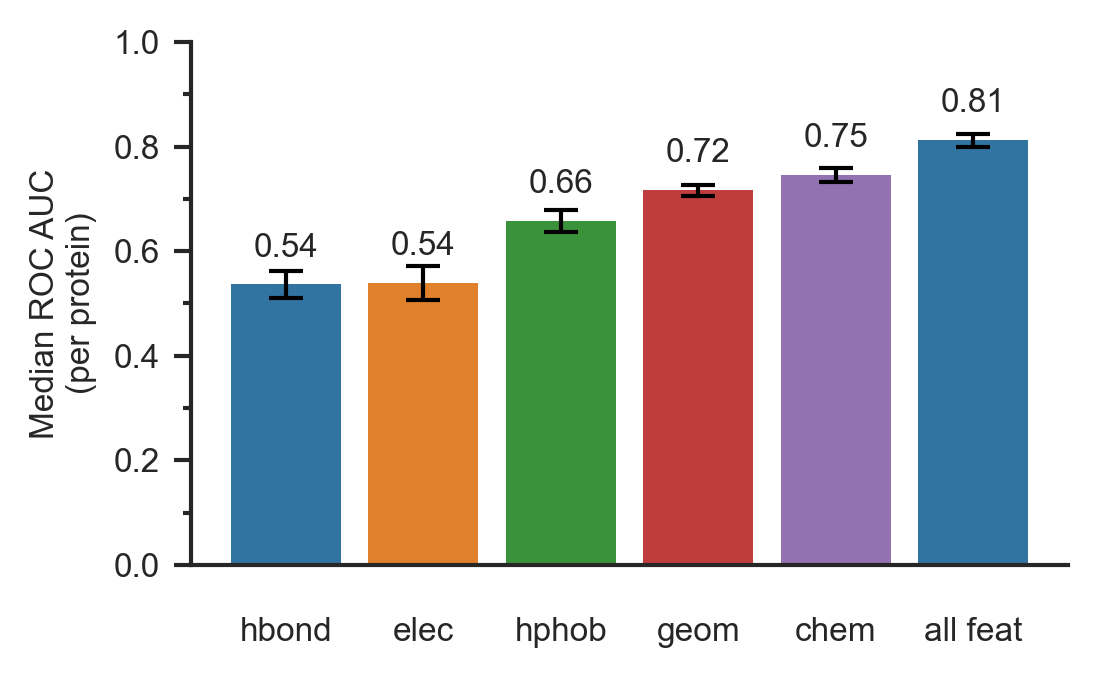

In [42]:
## 5-fold CV mask test plot
import seaborn as sns
sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})

mask_sets = ['hbond', 'elec', 'hphob', 'geom', 'chem', 'all feat']

xdata, ydata, yerr = [], [], []
for ms in mask_sets:
    row = df_all.loc[df_all['mask_set'] == ms]
    if row.empty:
        print(f"No data for mask_set='{ms}', skipping.")
        continue

    val_list = row['val_median'].iloc[0]   # list of 5 medians (validation)
    ydata.append(float(np.mean(val_list)))
    yerr.append(float(np.std(val_list)))
    xdata.append(ms)

f, ax1 = plt.subplots(1, 1, figsize=(4.0, 2.6), sharex=False)
ax1.set_ylim(0.0, 1.0)

palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'][:len(xdata)]

sns.barplot(x=xdata, y=ydata, ax=ax1, palette=palette, ci=None)

# Add error bars centered on each bar
xpos = np.arange(len(xdata))
ax1.errorbar(xpos, ydata, yerr=yerr, fmt='none', color='black',
             capsize=4, elinewidth=1)

# Value labels above bars (centered)
for i, y in enumerate(ydata):
    ax1.text(i, y + 0.04, f"{y:.2f}", ha='center', va='bottom', fontsize=8)

ax1.set_xticklabels(xdata, fontsize=8)
ax1.set_ylabel('Median ROC AUC\n(per protein)', fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add ticks
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='y', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

# save_path = 'figure'
# os.makedirs(save_path, exist_ok=True)
plt.tight_layout()
# plt.savefig(f'{save_path}/5-cv_auc_wrt_mask_sns.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


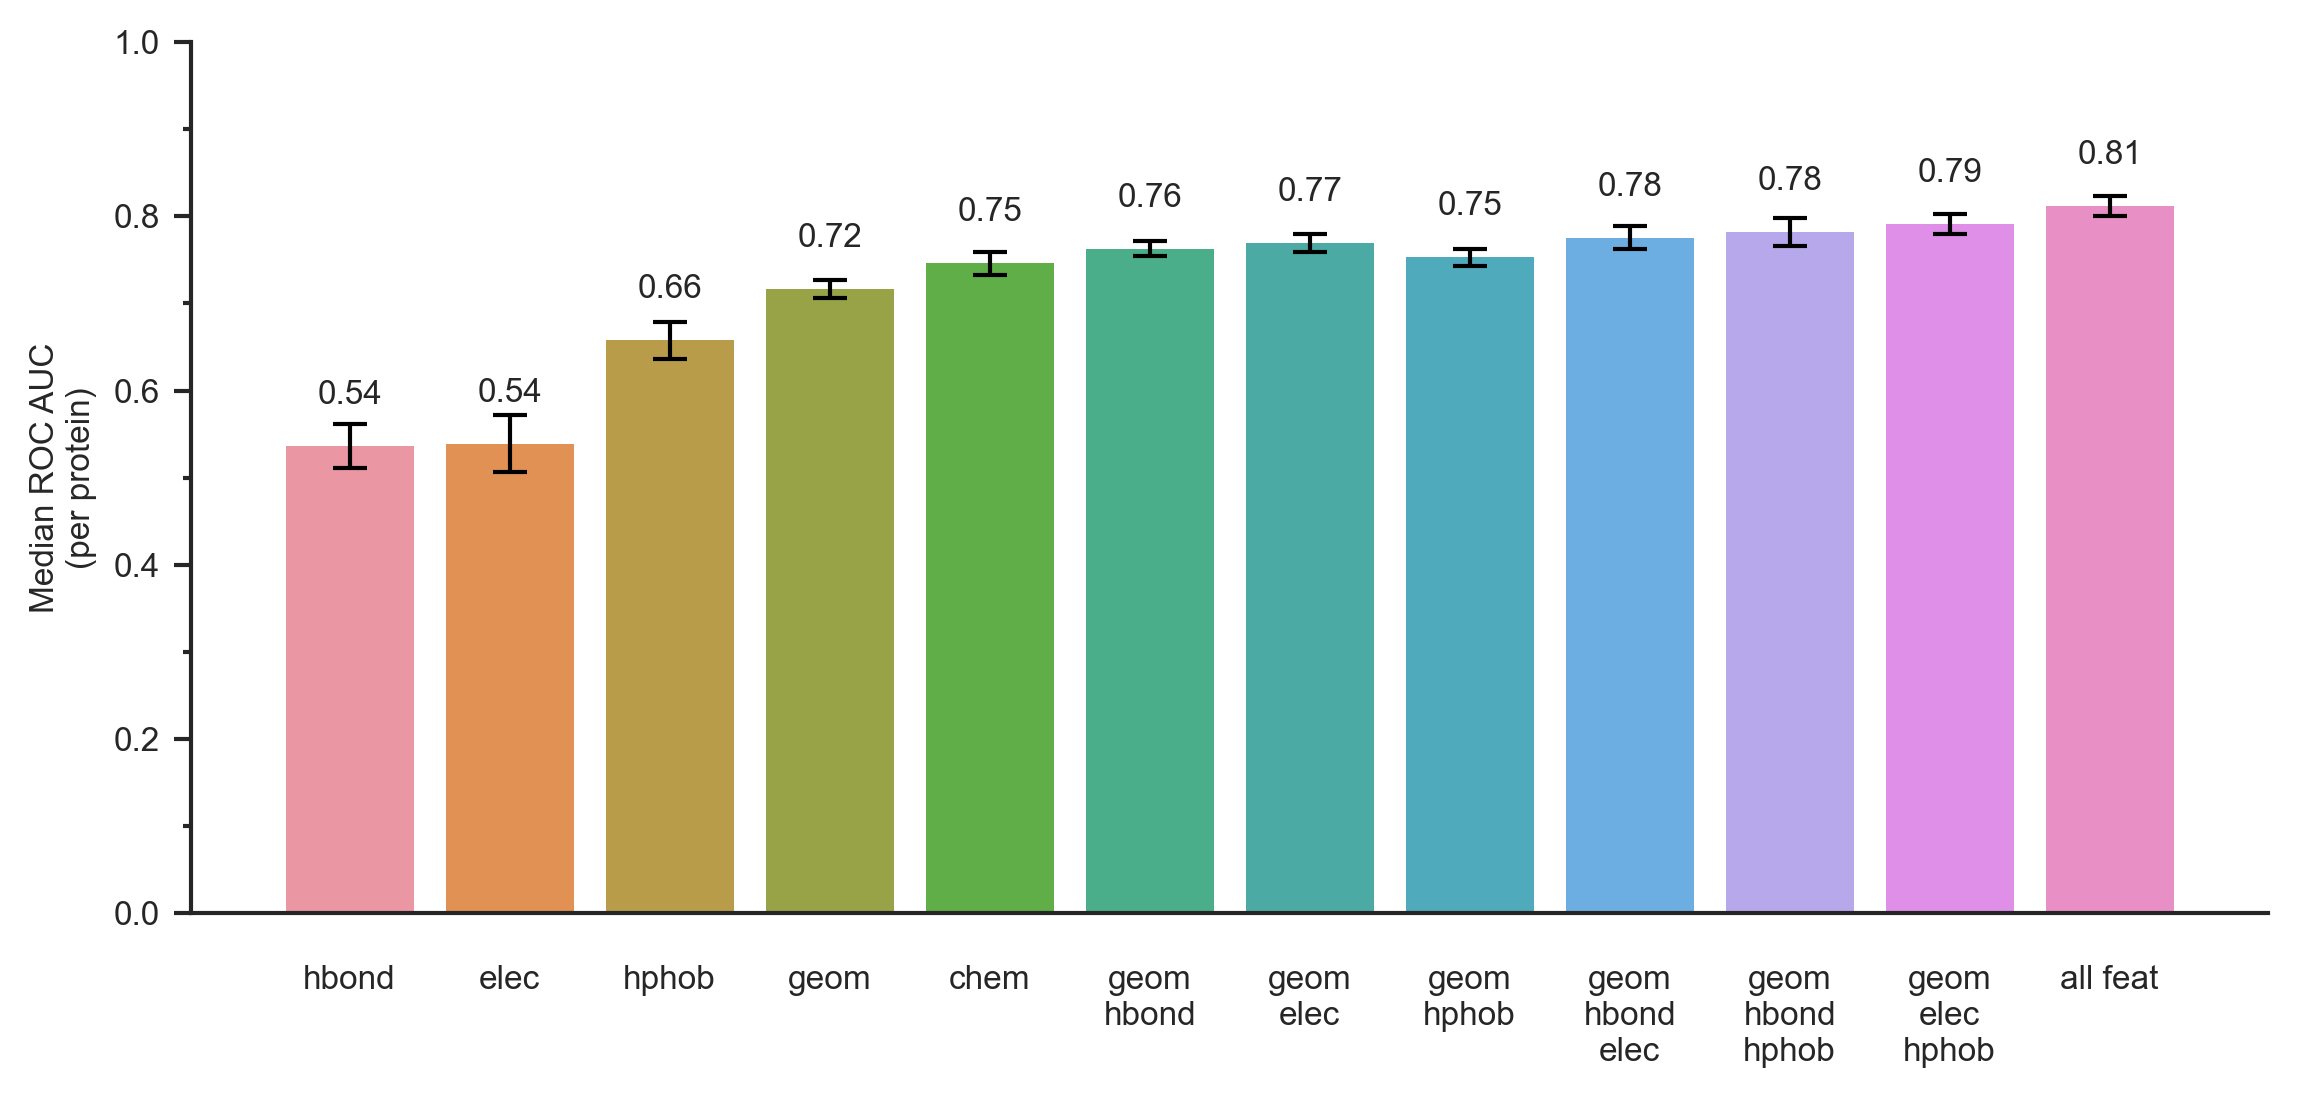

In [44]:
## 5-fold CV mask test plot
import seaborn as sns

mask_sets = ['hbond', 'elec', 'hphob', 'geom', 'chem', 'geom\nhbond', 'geom\nelec', 'geom\nhphob', 'geom\nhbond\nelec', 'geom\nhbond\nhphob', 'geom\nelec\nhphob', "all feat"]

# Setup of the plot
sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})
x = np.arange(0, 1.5*len(mask_sets), 1.5)  # Increase the step size to 1.5
width = 0.5
f, ax1 = plt.subplots(1, 1, figsize=(8, 4), sharex=False)

xdata, ydata, yerr = [], [], []
for i, mask_set in enumerate(mask_sets):
    row = df_all.loc[df_all['mask_set'] == mask_set]
    if row.empty:
        print(f"No data for mask_set='{mask_set}', skipping.")
        continue

    # train_list = row['train_median'].iloc[0]      # list of 5 medians
    val_list   = row['val_median'].iloc[0]        # list of 5 medians
    ydata.append(float(np.mean(val_list)))
    yerr.append(float(np.std(val_list)))
    xdata.append(mask_set)

ax1.set_ylim(0.0, 1.0)

# palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'][:len(xdata)]
sns.barplot(x=xdata, y=ydata, ax=ax1, ci=None)

# Add error bars centered on each bar
xpos = np.arange(len(xdata))
ax1.errorbar(xpos, ydata, yerr=yerr, fmt='none', color='black',
             capsize=4, elinewidth=1)

# Value labels above bars (centered)
for i, y in enumerate(ydata):
    ax1.text(i, y + 0.04, f"{y:.2f}", ha='center', va='bottom', fontsize=8)

ax1.set_xticklabels(xdata, fontsize=8)
ax1.set_ylabel('Median ROC AUC\n(per protein)', fontsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add ticks
ax1.margins(y=0)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='y', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='x', labelsize=8)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)

plt.tight_layout()
# plt.savefig(f"{save_path}/5-cv_auc_wrt_mask_all_valid-only.eps", format='eps', bbox_inches = 'tight', dpi=300)
plt.show()

### 4. Transfer Learning Comparison

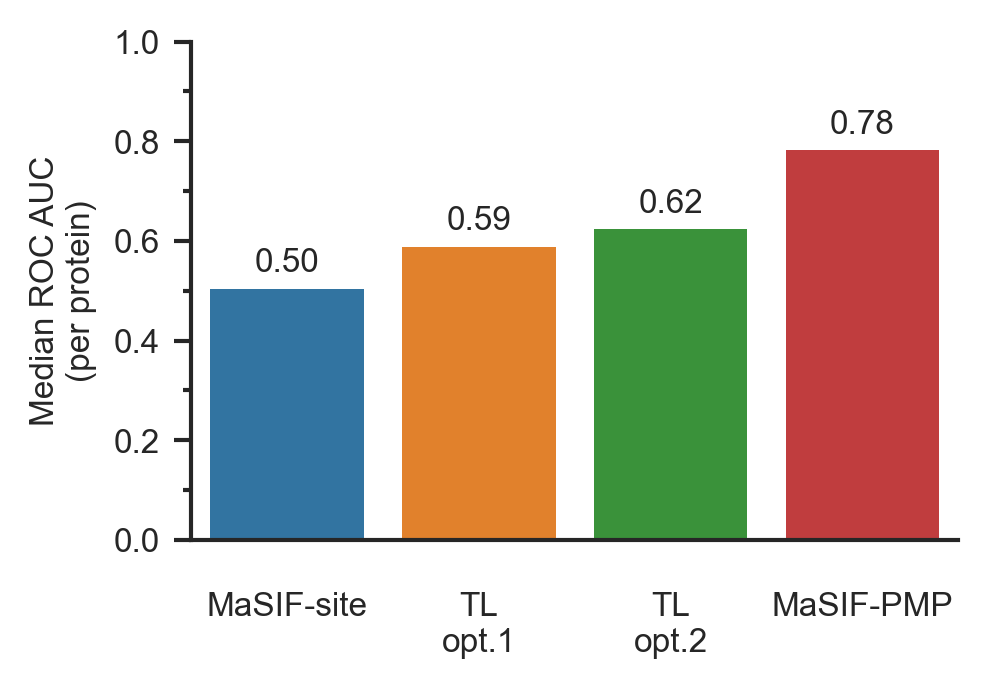

In [45]:
# median ROC AUC per protein w/ pmp test set (130)

masif_site = 0.5044
tflr_opt1 = 0.5885
tflr_opt2 = 0.6233
masif_pmp = 0.7823            # for convl5: 0.83

import seaborn as sns
sns.set(style="white", context="talk", rc={"patch.edgecolor": "none"})

xdata = ['MaSIF-site', 'TL\nopt.1', 'TL\nopt.2', 'MaSIF-PMP' ]
ydata = [masif_site, tflr_opt1, tflr_opt2, masif_pmp]

## plots for ROC AUC
f, (ax1) = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

plt.ylim([0.5,1.0])

sns.barplot(x=xdata, y=ydata, ax=ax1, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])  # palette=['lightgray', 'blue', 'lightgreen', 'pink']
ax1.set_xticklabels(xdata, fontsize=8)

ax1.set_ylim([0,1])

for p, v in zip(ax1.patches, ydata):
    ax1.text(p.get_x() + p.get_width()/2, v + 0.02, f'{v:.2f}',
             ha='center', va='bottom', fontsize=8)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add ticks
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.tick_params(axis='y', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax1.tick_params(axis='y', labelsize=8, which='minor', length=2, width=1, direction='out', bottom=True, left=True)
ax1.spines['bottom'].set_linewidth(1.0)
ax1.spines['left'].set_linewidth(1.0)


## per protein, point level ROC AUC
ax1.set_ylabel('Median ROC AUC\n(per protein)', fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
# plt.savefig(f'{save_path}/tflr_auc_comparison.eps', format='eps', bbox_inches = 'tight', dpi=300)
plt.show()

### 5. Data Augmentation Comparison

In [48]:
### Functions for Analysis ###
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde

def load_auc_df(log_file_path):
    pdb_id_list = []
    auc_list = []
    with open(log_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("ROC AUC score for protein"):
                fields = line.split()
                pdb_chain_id, auc = fields[5], fields[7]
                pdb_id_list.append(pdb_chain_id)
                auc_list.append(float(auc))
    df = pd.DataFrame({'pdb_id': pdb_id_list, 'auc': auc_list})
    return df


no data aug
----------------
Mean AUC: 0.76
Median AUC: 0.78

w. full data aug
----------------
Mean AUC: 0.77
Median AUC: 0.78



c:\Users\bpark74\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\bpark74\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


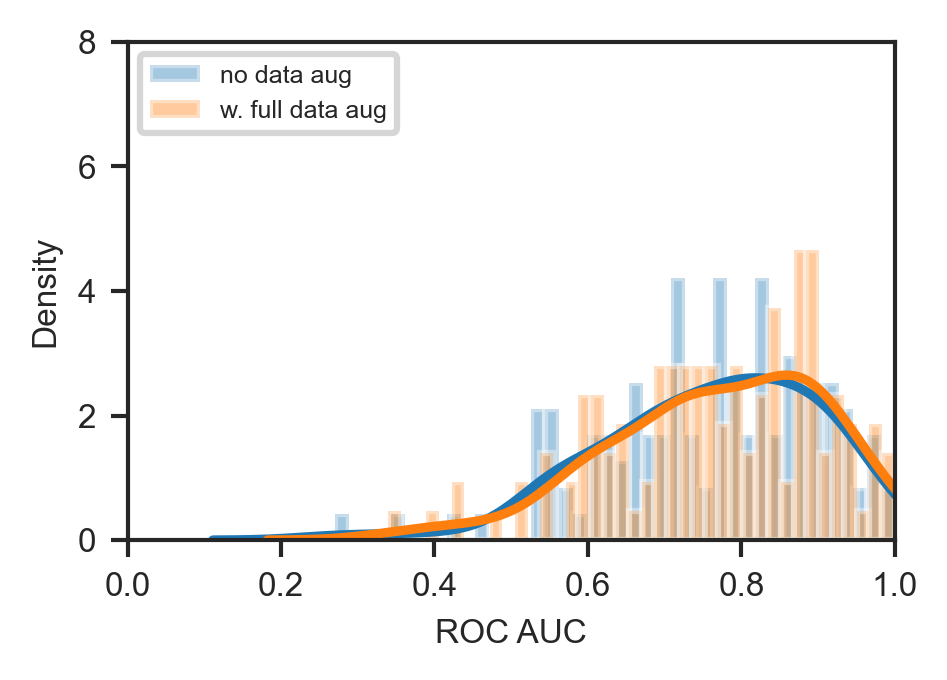

In [49]:
## AUC distribution plot

import seaborn as sns
sns.set(style="white", context="talk")

### execute ###

log_file_path1 = "input/test_log.txt"
log_file_path2 = "input/data_aug/log"
df1 = load_auc_df(log_file_path1)
df2 = load_auc_df(log_file_path2)

### density plot

f, ax = plt.subplots(1, 1, figsize=(3.3, 2.2), sharex=False)

sns.distplot(df1['auc'], bins=40, color='tab:blue', label='no data aug', hist=True)
sns.distplot(df2['auc'], bins=40, color='tab:orange', label='w. full data aug', hist=True)

ax.set_xlabel('ROC AUC', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.tick_params(axis='both', labelsize=8, which='major', length=4, width=1, direction='out', bottom=True, left=True)
ax.spines['top'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['right'].set_linewidth(1.0)
ax.spines['left'].set_linewidth(1.0)
plt.legend(fontsize=6, loc='upper left')
# plt.savefig(f"{save_path}/roc_auc_density.eps", format='eps', bbox_inches = 'tight', dpi=300)

### output summary

summary_text = f"no data aug\n----------------\n"
summary_text += "Mean AUC: {:.2f}".format(df1['auc'].mean())
summary_text += "\nMedian AUC: {:.2f}\n".format(df1['auc'].median())
summary_text += f"\nw. full data aug\n----------------\n"
summary_text += "Mean AUC: {:.2f}".format(df2['auc'].mean())
summary_text += "\nMedian AUC: {:.2f}\n".format(df2['auc'].median())
print(summary_text)

plt.show()
